In [1]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from keras import backend as K
from keras.optimizers import Adam, SGD
from tensorflow.keras import applications
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Add, Activation, AveragePooling2D, UpSampling2D, Conv2D, Input, Concatenate, BatchNormalization
from keras.models import Model

In [2]:
path = 'Cam101/'

# Load Images

In [3]:
def load_label_colors():

    label_colors = {}
    index = 0
    with open('Cam101/label_colors.txt', 'r') as f:
        for line in f:
            r, g, b, _ = line.strip().split()
            r, g, b = int(r), int(g), int(b)
            # store the r, g, b values in label_colors dictionary
            label_colors[(r, g, b)] = index
            index += 1

    return label_colors

In [4]:
def load_colors():

    label_colors = {}
    index = 0
    with open('Cam101/label_colors.txt', 'r') as f:
        for line in f:
            r, g, b, _ = line.strip().split()
            r, g, b = int(r), int(g), int(b)
            # store the r, g, b values in label_colors dictionary
            label_colors[index] = (r, g, b)
            index += 1

    return label_colors


In [5]:
label_colors = load_label_colors()

In [6]:
colors = load_colors()

In [7]:
def convert_mask(mask, label_colors):
    # Extract R, G, and B channels
    channels = mask.transpose((2, 0, 1)) * 255  # Shape: (3, height, width)
    r, g, b = channels
    
    # Convert RGB values to label indices using label_colors dictionary
    index = np.zeros((720, 960), dtype=np.uint8)
    for rgb, label in label_colors.items():
        mask = np.logical_and.reduce((r == rgb[0], g == rgb[1], b == rgb[2]))
        index[mask] = label
    
    # One-hot encode the label indices
    new_mask = np.eye(32, dtype=np.uint8)[index]
    
    return new_mask

In [8]:
def post_process_mask(mask, colors):
    # Get the label indices from the one-hot encoded mask
    index = np.argmax(mask, axis=2)
    
    # Convert label indices to RGB values using label_colors dictionary
    r, g, b = np.zeros_like(index), np.zeros_like(index), np.zeros_like(index)
    for label, rgb in colors.items():
        mask = index == label
        r[mask], g[mask], b[mask] = rgb
    
    # Stack R, G, and B channels to form the color-encoded mask
    color_mask = np.stack([r, g, b], axis=-1)
    
    return color_mask

In [9]:
train = {
    'img' : [],
    'mask' : []
}

test = {
    'img' : [],
    'mask' : []
}

In [10]:
# fucntion for loading images and masks
def load_images(frame_obj = None, image_path = None):
    
    names = os.listdir(image_path)
    
    image_names = []
    mask_names = []
    
    # generating mask names
    for name in names:
        if name.split('_')[-1][0] == 'L':
            mask_names.append(name)
        else:
            image_names.append(name)

    image_names.sort()
    mask_names.sort()
    
    
    for i in range (len(image_names)):
        # read image and mask
        img = plt.imread(image_path + '/' + image_names[i])
        mask = plt.imread(image_path + '/' + mask_names[i])
        
        frame_obj['img'].append(img)
        frame_obj['mask'].append(mask)
        
    return frame_obj

        

In [11]:
train = load_images(train, path + 'train')
test = load_images(test, path + 'test')

# Data Exploration

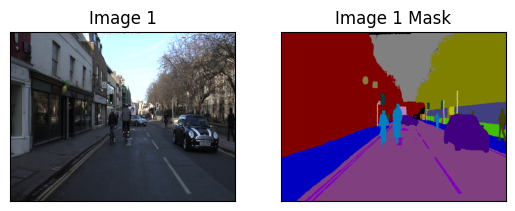

In [12]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(train['img'][0])
axes[0].title.set_text('Image 1')

axes[1].imshow(train['mask'][0])
axes[1].title.set_text('Image 1 Mask')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])


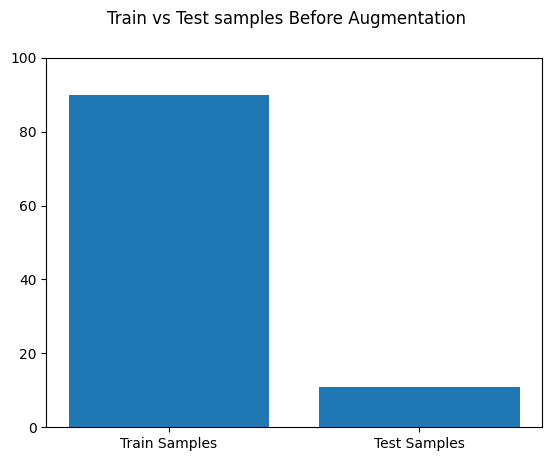

In [13]:
train_samples = len(train['img'])
test_samples = len(test['img'])

plt.bar(['Train Samples', 'Test Samples'], [train_samples, test_samples])
plt.ylim(0, 100)
plt.suptitle('Train vs Test samples Before Augmentation')
plt.show()

In [14]:
print(f'Number of train samples before augmentation: {train_samples}')
print(f'Number of test samples before augmentation: {test_samples}')

Number of train samples: 90
Number of test samples: 11


# Data Augmentation

In [15]:
# make augmentation pipeline
transform = A.Compose([
    A.RandomCrop(width=960, height=720),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=90, p=0.5),
    A.GridDistortion(p=0.5),
])

augmented_images = []
augmented_masks = []

# augment the training images
for image, mask in zip(train['img'], train['mask']):
     for _ in range(3):
        augmented = transform(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])
  

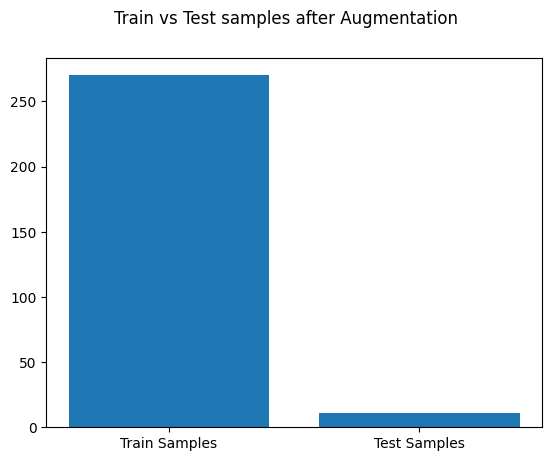

In [24]:
plt.bar(['Train Samples', 'Test Samples'], [len(augmented_images), test_samples])
plt.suptitle('Train vs Test samples after Augmentation')
plt.show()

In [21]:
print(f'Number of train samples after augmentation: {len(augmented_images)}')
print(f'Number of test samples after augmentation: {test_samples}')

Number of train samples after augmentation: 270
Number of test samples after augmentation: 11


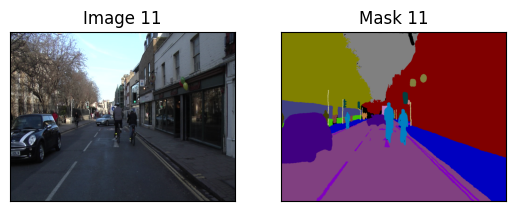

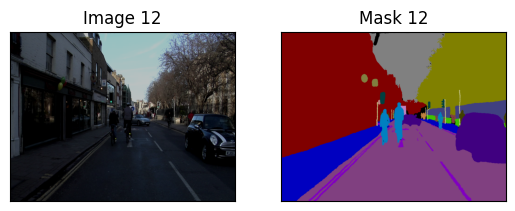

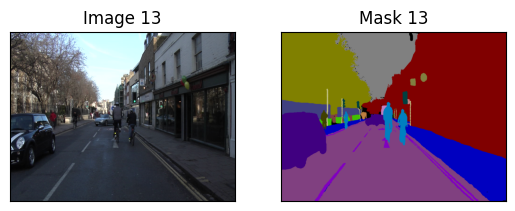

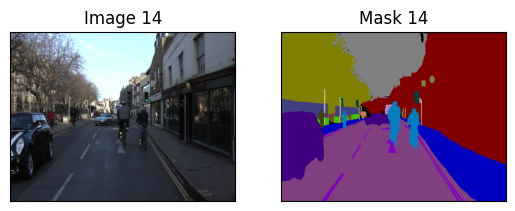

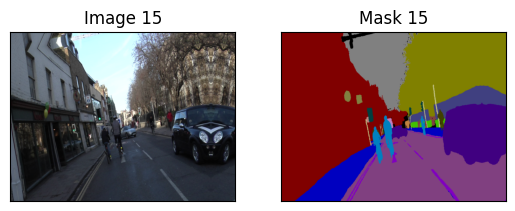

In [16]:
for i in range(10, 15):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(augmented_images[i])
    axes[0].title.set_text('Image'+" " + str(i+1))

    axes[1].imshow(augmented_masks[i])
    axes[1].title.set_text('Mask' + " " + str(i+1))

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])


In [19]:
# process masks
processed_masks = []
for mask in augmented_masks:
    processed_masks.append(convert_mask(mask, label_colors))

In [20]:
# process test masks
processed_test_masks = []
for mask in test['mask']:
    # convert the channels from 3 to 32
    processed_test_masks.append(convert_mask(mask, label_colors))

In [21]:
train_images = []
test_images = []
test_mask_images = [] # resized 32 channel test masks
mask_images = []
test_masks = [] # resized 3 channel test masks
shape = 256

# reshape train image and mask
for image, mask in zip(augmented_images, processed_masks):
    train_images.append(cv2.resize(image, (shape, shape)))
    mask_images.append(cv2.resize(mask, (shape, shape)))

# reshape test masks
for mask in test['mask']:
    test_masks.append(cv2.resize(mask, (shape, shape)))


# reshape test image and mask
for image, mask in zip(test['img'], processed_test_masks):
    test_images.append(cv2.resize(image, (shape, shape)))
    test_mask_images.append(cv2.resize(mask, (shape, shape)))


In [22]:
X_train = np.array(train_images[:243])
X_val = np.array(train_images[243:])
y_train = np.array(mask_images[:243])
y_val = np.array(mask_images[243:])

X_test = np.array(test_images)
y_test = np.array(test_mask_images)

# DiceLoss Function

In [23]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, gama=2, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        # cast the ground truth and predicted labels to float32
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        # calculate the nominator for Dice coefficient
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        # calculate the denominator for Dice coefficient
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth

        result = 1 - tf.divide(nominator, denominator) # calculate dice coeff
        return result

# Evaluation Functions

In [24]:
def iou_coef(y_true, y_pred, smooth=1):
    
    # calculate the intersection between the predicted and ground truth labels
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    # calculate the union of predicted and ground truth labels
    union = K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection
    # calculate iou
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou



In [26]:
def pixel_wise_accuracy(y_true, y_pred):
    # flatten the ground truth and predicted labels and find index of max values
    y_true_flat = np.argmax(y_true, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

    # Calculate pixel-wise accuracy
    accuracy = np.mean(y_true_flat == y_pred_flat)

    return accuracy

# HyperParameters for tuning

In [28]:
optimizers = [Adam,SGD]
losses = ['dice', 'categorical_crossentropy']
lr_schedulers = [tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9),
                tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=1000)]


# Hyper Parameter Tuning Function

In [27]:
def best_parameters(seg_model):
    best_accuracy = 0.0
    best_optimizer = None
    best_loss = None
    best_lr_scheduler = None

    # Iterate over optimizer and loss options
    for optimizer in optimizers:
        for loss in losses:
            for lr_scheduler in lr_schedulers:
                # Build the segmentation model with the current hyperparameters
                model = seg_model(optimizer=optimizer, loss=loss, lr_scheduler=lr_scheduler)

                # Train the model on the training set
                model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1)

                accuracy = model.evaluate(X_val, y_val, verbose=2)[1]

                # Check if the current hyperparameters yield better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy # update best accuracy
                    best_optimizer = optimizer
                    best_loss = loss
                    best_lr_scheduler = lr_scheduler

    return best_optimizer, best_loss, best_lr_scheduler, best_accuracy


# FCN 


## Define Model

In [31]:
def fcn(optimizer=Adam,loss='categorical_crossentropy',lr_scheduler=None):
    # input layer
    input_tensor = Input(shape=(256, 256, 3))

    # base model
    vgg = applications.VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(32, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(32, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    # decoding layers
    deconv_7 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(32, kernel_size=(8,8), strides=(8,8))(add_2)
    
    output_layer = Activation('softmax')(deconv_9)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    # handle loss function
    if (loss=='dice'):
      model.compile(loss=DiceLoss(), optimizer=optimizer(learning_rate=0.001), metrics=['accuracy'])
    else:
     model.compile(loss=loss, optimizer=optimizer(learning_rate=lr_scheduler), metrics=['accuracy'])
    
    return model

## FCN Tuning

In [32]:
optimizer,loss,schedler,accuracy=best_parameters(fcn)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
31/31 [==============================] - 14s 73ms/step - loss: 0.6504 - accuracy: 0.3129
Epoch 2/10
31/31 [==============================] - 1s 36ms/step - loss: 0.3423 - accuracy: 0.6150
Epoch 3/10
31/31 [==============================] - 1s 36ms/step - loss: 0.2490 - accuracy: 0.7022
Epoch 4/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1960 - accuracy: 0.7559
Epoch 5/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1562 - accuracy: 0.8056
Epoch 6/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1327 - accuracy: 0.8354
Epoch 7/10
31/31 [==============================] - 1s 35ms/step - loss: 0.1260 - accuracy: 0.8442
Epoch 8/10
31/31 [==============================] - 1s 35ms/step - loss: 0.1092 - accuracy: 0.8646
Epoch 9/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1033 - accuracy: 0.8708
Epoch 10/10
31/31 [========================

1/1 - 0s - loss: 0.9396 - accuracy: 0.0305 - 337ms/epoch - 337ms/step
Epoch 1/10
31/31 [==============================] - 2s 35ms/step - loss: 0.9401 - accuracy: 0.0358
Epoch 2/10
31/31 [==============================] - 1s 35ms/step - loss: 0.9394 - accuracy: 0.0371
Epoch 3/10
31/31 [==============================] - 1s 35ms/step - loss: 0.9387 - accuracy: 0.0384
Epoch 4/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9381 - accuracy: 0.0398
Epoch 5/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9373 - accuracy: 0.0412
Epoch 6/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9366 - accuracy: 0.0427
Epoch 7/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9357 - accuracy: 0.0443
Epoch 8/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9348 - accuracy: 0.0461
Epoch 9/10
31/31 [==============================] - 1s 34ms/step - loss: 0.9339 - accuracy: 0.0480
Epoch 10/10
31/31 [====================

1/1 - 0s - loss: 0.9307 - accuracy: 0.0541 - 335ms/epoch - 335ms/step
Epoch 1/10
31/31 [==============================] - 2s 35ms/step - loss: 3.7943 - accuracy: 0.0321
Epoch 2/10
31/31 [==============================] - 1s 35ms/step - loss: 3.5643 - accuracy: 0.0469
Epoch 3/10
31/31 [==============================] - 1s 34ms/step - loss: 3.5044 - accuracy: 0.0578
Epoch 4/10
31/31 [==============================] - 1s 34ms/step - loss: 3.4697 - accuracy: 0.0671
Epoch 5/10
31/31 [==============================] - 1s 34ms/step - loss: 3.4441 - accuracy: 0.0751
Epoch 6/10
31/31 [==============================] - 1s 34ms/step - loss: 3.4220 - accuracy: 0.0830
Epoch 7/10
31/31 [==============================] - 1s 35ms/step - loss: 3.4010 - accuracy: 0.0910
Epoch 8/10
31/31 [==============================] - 1s 35ms/step - loss: 3.3795 - accuracy: 0.0991
Epoch 9/10
31/31 [==============================] - 1s 34ms/step - loss: 3.3562 - accuracy: 0.1074
Epoch 10/10
31/31 [====================

In [33]:
print("Best optimiser fcn :",optimizer)
print("Best loss fcn :",loss)
print("Best Scheduler fcn :",schedler)
print("Best Accuracy fcn :",accuracy)

Best optimiser fcn : <class 'keras.optimizers.legacy.adam.Adam'>
Best loss fcn : dice
Best Scheduler fcn : <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x7f014363dc60>
Best Accuracy fcn : 0.8804688453674316


## FCN Fit

In [34]:
model = fcn(
    optimizer = optimizer, 
    loss = loss, 
    lr_scheduler = schedler
)

In [35]:
start_time = time.time()
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=30, batch_size=8)
end_time = time.time()
total_time = end_time - start_time

Epoch 1/30
31/31 [==============================] - 3s 51ms/step - loss: 0.6684 - accuracy: 0.2970 - val_loss: 0.4119 - val_accuracy: 0.5415
Epoch 2/30
31/31 [==============================] - 1s 38ms/step - loss: 0.3140 - accuracy: 0.6491 - val_loss: 0.2276 - val_accuracy: 0.7183
Epoch 3/30
31/31 [==============================] - 1s 38ms/step - loss: 0.2599 - accuracy: 0.6974 - val_loss: 0.1835 - val_accuracy: 0.7678
Epoch 4/30
31/31 [==============================] - 1s 39ms/step - loss: 0.1901 - accuracy: 0.7627 - val_loss: 0.1582 - val_accuracy: 0.7974
Epoch 5/30
31/31 [==============================] - 1s 39ms/step - loss: 0.1614 - accuracy: 0.7977 - val_loss: 0.1367 - val_accuracy: 0.8262
Epoch 6/30
31/31 [==============================] - 1s 40ms/step - loss: 0.1401 - accuracy: 0.8246 - val_loss: 0.1257 - val_accuracy: 0.8387
Epoch 7/30
31/31 [==============================] - 1s 39ms/step - loss: 0.1211 - accuracy: 0.8480 - val_loss: 0.1113 - val_accuracy: 0.8584
Epoch 8/30
31

In [36]:
print('FCN total training time:', total_time)

FCN total training time: 38.016969203948975


In [37]:
model.save('fcn_best_model.h5')

## Loss accuracy plot

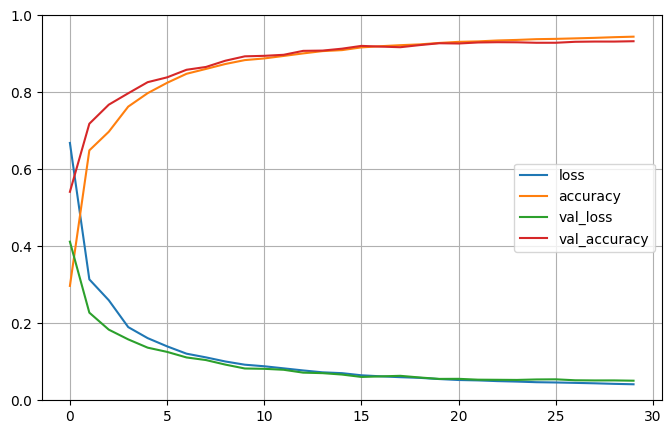

In [39]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()

## Prediction and Evaluation

In [40]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [41]:
y_pred_processed = []

for pred in y_pred:
    mask = post_process_mask(pred, colors)
    y_pred_processed.append(mask)


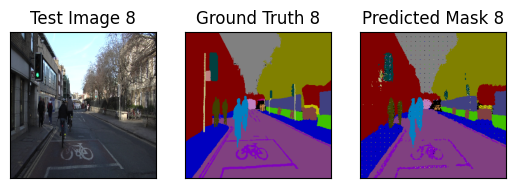

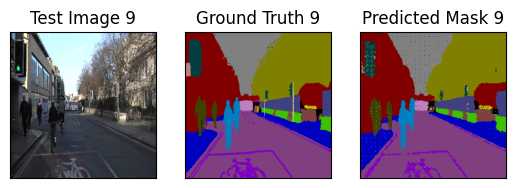

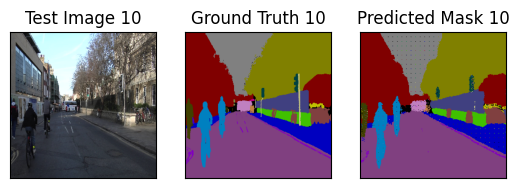

In [42]:
for i in range(7, 10):
    fig, axes = plt.subplots(1, 3)

    axes[0].imshow(X_test[i])
    axes[0].title.set_text('Test Image'+" " + str(i+1))

    axes[1].imshow(test_masks[i])
    axes[1].title.set_text('Ground Truth'+" " + str(i+1))

    axes[2].imshow(y_pred_processed[i])
    axes[2].title.set_text('Predicted Mask' + " " + str(i+1))

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

In [43]:
# IOU
iou_fcn = iou_coef(test_masks, np.array(
    y_pred_processed, dtype='float32')).numpy()
print('FCN mean IOU:', iou_fcn)

FCN mean IOU: 0.9725025


In [44]:
# pixel wise accuracy
pwa_fcn = pixel_wise_accuracy(y_test, y_pred)
print('FCN Pixel wise Accuracy:', pwa_fcn)

FCN Pixel wise Accuracy: 0.9362848455255682


# U-Net


## Define Model

In [45]:
def u_net(optimizer=Adam,loss='categorical_crossentropy',lr_scheduler=None):
    
    # input layer
    input_tensor = Input(shape=(256, 256, 3))
    # base model
    vgg_model= applications.VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)

    # encoders
    s1 = vgg_model.get_layer("block1_conv2").output         
    s2 = vgg_model.get_layer("block2_conv2").output         
    s3 = vgg_model.get_layer("block3_conv3").output         
    s4 = vgg_model.get_layer("block4_conv3").output         

    # bridge layers
    b1 = vgg_model.get_layer("block5_conv3").output   

    # decoders
    d1 = Conv2DTranspose(512, (2, 2), strides=2, padding="same")(b1)
    d1 = Concatenate()([d1, s4])
    d1 = Conv2D(512, 3, padding="same")(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation("relu")(d1)
    d1 = Conv2D(512, 3, padding="same")(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation("relu")(d1)
    
    d2 = Conv2DTranspose(256, (2, 2), strides=2, padding="same")(d1)
    d2 = Concatenate()([d2, s3])
    d2 = Conv2D(256, 3, padding="same")(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation("relu")(d2)
    d2 = Conv2D(256, 3, padding="same")(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation("relu")(d2)

    d3 = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(d2)
    d3 = Concatenate()([d3, s2])
    d3 = Conv2D(128, 3, padding="same")(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation("relu")(d3)
    d3 = Conv2D(128, 3, padding="same")(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation("relu")(d3)

    d4 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d3)
    d4 = Concatenate()([d4, s1])
    d4 = Conv2D(64, 3, padding="same")(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation("relu")(d4)
    d4 = Conv2D(64, 3, padding="same")(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation("relu")(d4)

    # output layer
    outputs = Conv2D(32, 1, padding="same", activation="sigmoid")(d4)

    model=Model(inputs=vgg_model.input, outputs=outputs)

    # handle loss function
    if (loss=='dice'):
      model.compile(loss=DiceLoss(), optimizer=optimizer(learning_rate=0.001), metrics=['accuracy'])
    else: 
      model.compile(loss=loss, optimizer=optimizer(learning_rate=lr_scheduler), metrics=['accuracy'])

    return model

## U-Net Tuning

In [46]:
optimizer_unet,loss_unet,schedler_unet,accuracy_unet=best_parameters(u_net)

Epoch 1/10
31/31 [==============================] - 8s 105ms/step - loss: 0.7665 - accuracy: 0.6273
Epoch 2/10
31/31 [==============================] - 2s 63ms/step - loss: 0.4796 - accuracy: 0.7401
Epoch 3/10
31/31 [==============================] - 2s 62ms/step - loss: 0.2329 - accuracy: 0.7866
Epoch 4/10
31/31 [==============================] - 2s 63ms/step - loss: 0.1480 - accuracy: 0.8435
Epoch 5/10
31/31 [==============================] - 2s 63ms/step - loss: 0.1296 - accuracy: 0.8534
Epoch 6/10
31/31 [==============================] - 2s 63ms/step - loss: 0.1048 - accuracy: 0.8795
Epoch 7/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0904 - accuracy: 0.8940
Epoch 8/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0815 - accuracy: 0.9015
Epoch 9/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0800 - accuracy: 0.9029
Epoch 10/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0762 - accuracy: 0.9066
1/1 - 3s

In [47]:
print("Best optimiser unet :",optimizer_unet)
print("Best loss unet :",loss_unet)
print("Best Scheduler unet :",schedler_unet)
print("Best Accuracy unet :",accuracy_unet)

Best optimiser unet : <class 'keras.optimizers.legacy.adam.Adam'>
Best loss unet : categorical_crossentropy
Best Scheduler unet : <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x7f014363dc60>
Best Accuracy unet : 0.9140257835388184


## U-Net Fit

In [48]:
model = u_net(
    optimizer = optimizer_unet, 
    loss = loss_unet, 
    lr_scheduler = schedler_unet
)

In [49]:
start_time = time.time()
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=30, batch_size=8)
end_time = time.time()
total_time = end_time - start_time

Epoch 1/30
31/31 [==============================] - 5s 83ms/step - loss: 1.6014 - accuracy: 0.6409 - val_loss: 38.9758 - val_accuracy: 0.3425
Epoch 2/30
31/31 [==============================] - 2s 66ms/step - loss: 0.7763 - accuracy: 0.7971 - val_loss: 58.5959 - val_accuracy: 0.1769
Epoch 3/30
31/31 [==============================] - 2s 66ms/step - loss: 0.5852 - accuracy: 0.8382 - val_loss: 4.7412 - val_accuracy: 0.3897
Epoch 4/30
31/31 [==============================] - 2s 66ms/step - loss: 0.4715 - accuracy: 0.8663 - val_loss: 1.6872 - val_accuracy: 0.5662
Epoch 5/30
31/31 [==============================] - 2s 67ms/step - loss: 0.4601 - accuracy: 0.8621 - val_loss: 0.9689 - val_accuracy: 0.7115
Epoch 6/30
31/31 [==============================] - 2s 66ms/step - loss: 0.4076 - accuracy: 0.8793 - val_loss: 1.3288 - val_accuracy: 0.6554
Epoch 7/30
31/31 [==============================] - 2s 66ms/step - loss: 0.3989 - accuracy: 0.8770 - val_loss: 0.9134 - val_accuracy: 0.7595
Epoch 8/30


In [50]:
print('U-Net total training time:', total_time)

U-Net total training time: 64.57817888259888


In [51]:
model.save('unet_best_model.h5')

## Loss Accuracy Plot

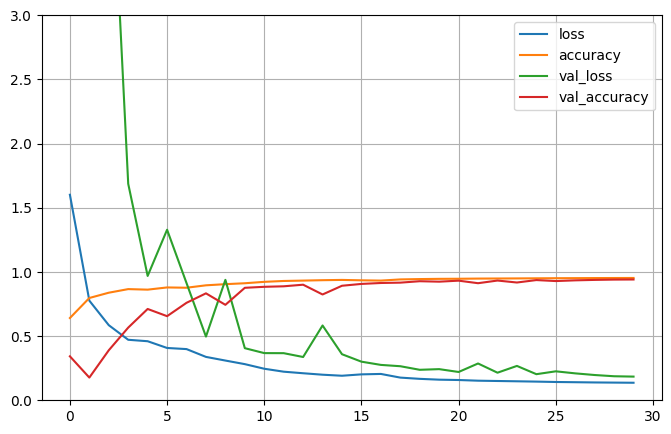

In [62]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)  # set the vertical range to [0-3]
plt.show()

## Prediction and Evaluation

In [63]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 30ms/step


In [64]:
y_pred_processed = []

for pred in y_pred:
  mask = post_process_mask(pred, colors)
  y_pred_processed.append(mask)

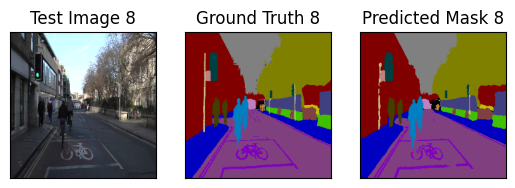

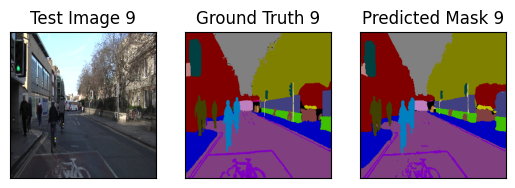

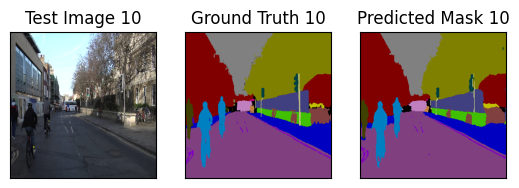

In [65]:
for i in range(7, 10):
    fig, axes = plt.subplots(1, 3)

    axes[0].imshow(X_test[i])
    axes[0].title.set_text('Test Image'+" " + str(i+1))

    axes[1].imshow(test_masks[i])
    axes[1].title.set_text('Ground Truth'+" " + str(i+1))

    axes[2].imshow(y_pred_processed[i])
    axes[2].title.set_text('Predicted Mask' + " " + str(i+1))

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

In [66]:
# IOU
iou_unet = iou_coef(test_masks, np.array(
    y_pred_processed, dtype='float32')).numpy()
print('U-Net mean IOU:', iou_unet)

U-Net mean IOU: 0.98295766


In [67]:
# pixel wise accuracy
pwa_unet = pixel_wise_accuracy(y_test, y_pred)
print('U-Net Pixel wise Accuracy:', pwa_unet)

U-Net Pixel wise Accuracy: 0.9539517489346591


# DeepLab v3 plus


## Define Model

In [68]:
def ASPP(inputs):
    # shape of input layer
    shape = inputs.shape

    # pooling layer
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [69]:
def deeplab(optimizer=Adam,loss='categorical_crossentropy',lr_scheduler=None):

    # input layer
    inputs = Input((256,256,3))

    # using pre trained resnet50
    resnet50 = applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # get resnet50 output
    resnet_output = resnet50.get_layer('conv4_block6_out').output
    x_a = ASPP(resnet_output)
    x_a = UpSampling2D((4, 4), interpolation='bilinear')(x_a) # upsampling 4 times
    
    resnet_lowlevel = resnet50.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(resnet_lowlevel)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    for _ in range(2):
        x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x) # upsampling 4 times

    # output layers
    outputs = Conv2D(32, (1, 1), name='output_layer')(x)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs = inputs, outputs=outputs)

    if (loss=='dice'):
        model.compile(loss=DiceLoss(), optimizer=optimizer(learning_rate=0.001), metrics=['accuracy'])
    else:
        model.compile(loss=loss, optimizer=optimizer(learning_rate=lr_scheduler), metrics=['accuracy'])
    return model

## Deeplab Tuning

In [95]:
optimizer_deep,loss_deep,schedler_deep,accuracy_deep=best_parameters(deeplab)

Epoch 1/10
31/31 [==============================] - 7s 50ms/step - loss: 0.4593 - accuracy: 0.7896
Epoch 2/10
31/31 [==============================] - 2s 50ms/step - loss: 0.1109 - accuracy: 0.8770
Epoch 3/10
31/31 [==============================] - 2s 50ms/step - loss: 0.0788 - accuracy: 0.9038
Epoch 4/10
31/31 [==============================] - 2s 50ms/step - loss: 0.0684 - accuracy: 0.9155
Epoch 5/10
31/31 [==============================] - 2s 48ms/step - loss: 0.0644 - accuracy: 0.9198
Epoch 6/10
31/31 [==============================] - 2s 49ms/step - loss: 0.0555 - accuracy: 0.9298
Epoch 7/10
31/31 [==============================] - 2s 49ms/step - loss: 0.0512 - accuracy: 0.9343
Epoch 8/10
31/31 [==============================] - 2s 49ms/step - loss: 0.0478 - accuracy: 0.9383
Epoch 9/10
31/31 [==============================] - 1s 48ms/step - loss: 0.0451 - accuracy: 0.9414
Epoch 10/10
31/31 [==============================] - 1s 48ms/step - loss: 0.0424 - accuracy: 0.9444
1/1 - 1s 

In [96]:
print("Best optimizer Deeplab:",optimizer_deep)
print("Best loss Deeplab:", loss_deep)
print("Best scheduler Deeplab:",schedler_deep)

Best optimizer Deeplab: <class 'keras.optimizers.legacy.adam.Adam'>
Best loss Deeplab: dice
Best scheduler Deeplab: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7f014363e650>


## Deeplab Fit

In [97]:
model = deeplab(
    optimizer = optimizer_deep, 
    loss = loss_deep, 
    lr_scheduler = schedler_deep
)

In [98]:
start_time = time.time()
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=30, batch_size=8)
end_time = time.time()
total_time = end_time - start_time

Epoch 1/30
31/31 [==============================] - 8s 87ms/step - loss: 0.4341 - accuracy: 0.7800 - val_loss: 0.8876 - val_accuracy: 0.1119
Epoch 2/30
31/31 [==============================] - 2s 51ms/step - loss: 0.1089 - accuracy: 0.8749 - val_loss: 0.6452 - val_accuracy: 0.3357
Epoch 3/30
31/31 [==============================] - 2s 53ms/step - loss: 0.0865 - accuracy: 0.8947 - val_loss: 0.7748 - val_accuracy: 0.1187
Epoch 4/30
31/31 [==============================] - 2s 52ms/step - loss: 0.0721 - accuracy: 0.9119 - val_loss: 0.6575 - val_accuracy: 0.3336
Epoch 5/30
31/31 [==============================] - 2s 51ms/step - loss: 0.0611 - accuracy: 0.9237 - val_loss: 0.6487 - val_accuracy: 0.3348
Epoch 6/30
31/31 [==============================] - 2s 51ms/step - loss: 0.0550 - accuracy: 0.9307 - val_loss: 0.6531 - val_accuracy: 0.3267
Epoch 7/30
31/31 [==============================] - 2s 52ms/step - loss: 0.0514 - accuracy: 0.9342 - val_loss: 0.6388 - val_accuracy: 0.3290
Epoch 8/30
31

In [99]:
print('Deeplab total training time:', total_time)

Deeplab total training time: 54.994980335235596


In [100]:
model.save('deeplab_best_model.h5')

## Loss Accuracy Plot

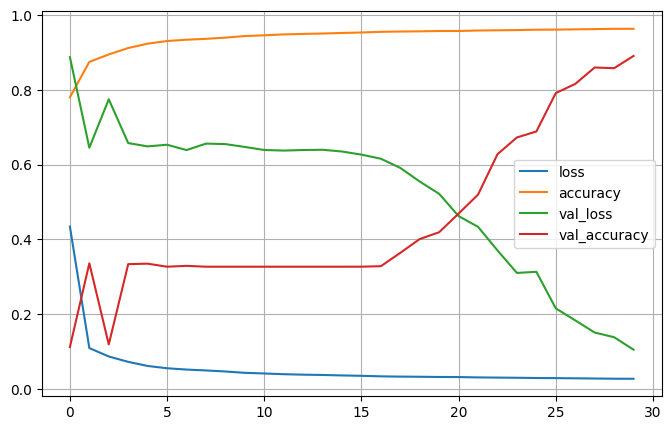

In [101]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## Prediction and Evaluation

In [102]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [103]:
y_pred_processed = []

for pred in y_pred:
  mask = post_process_mask(pred, colors)
  y_pred_processed.append(mask)

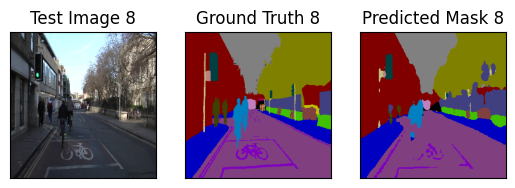

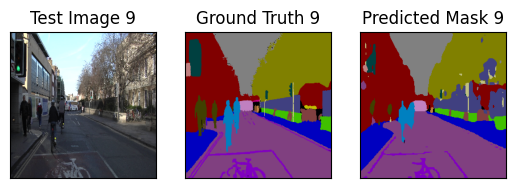

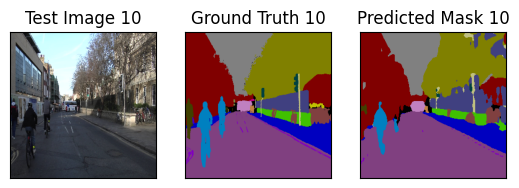

In [104]:
for i in range(7, 10):
    fig, axes = plt.subplots(1, 3)

    axes[0].imshow(X_test[i])
    axes[0].title.set_text('Test Image'+" " + str(i+1))

    axes[1].imshow(test_masks[i])
    axes[1].title.set_text('Ground Truth'+" " + str(i+1))

    axes[2].imshow(y_pred_processed[i])
    axes[2].title.set_text('Predicted Mask' + " " + str(i+1))

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

In [105]:
# IOU
iou_deeplab = iou_coef(test_masks, np.array(
    y_pred_processed, dtype='float32')).numpy()
print('DeepLab mean IOU:', iou_deeplab)

DeepLab mean IOU: 0.92246747


In [106]:
# pixel wise accuracy
pwa_deeplab = pixel_wise_accuracy(y_test, y_pred)
print('DeepLab Pixel wise Accuracy:', pwa_deeplab)

DeepLab Pixel wise Accuracy: 0.8875080455433239


# Comparison

In [107]:
metrics = {
    'Mean Intersection over Union (IoU)': [iou_fcn, iou_unet, iou_deeplab],
    'Pixel Accuracy': [pwa_fcn, pwa_unet, pwa_deeplab]
}

models = ['FCN-8', 'U-Net', 'Deeplab V3+']

pd.DataFrame(metrics, index=models)

,Mean Intersection over Union (IoU),Pixel Accuracy
FCN-8,0.972503,0.936285
U-Net,0.982958,0.953952
Deeplab V3+,0.922467,0.887508
